In [758]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import pytorch_lightning as pl

## Data

In [667]:
def generate_data(frequency: str, num_of_samples: int, start_date: pd.Timestamp, end_date:pd.Timestamp):
    data_dates = pd.date_range(start_date, end_date, freq=frequency)
    # create sinusoidal time seris from start-end time range
    data = {
        i: [random.uniform(-1, 1) * np.sin(random.randint(1, 100)) for _ in range(len(data_dates))]
        for i in range(num_of_samples)
    }
    
    data_df = pd.DataFrame(index=pd.DatetimeIndex(data_dates), data=data)
    covariate_df = pd.DataFrame(index=data_df.index)
    
    # Adding calendar features
    covariate_df["yearly_cycle"] = np.sin(2 * np.pi * covariate_df.index.dayofyear / 366)
    covariate_df["weekly_cycle"] = np.sin(2 * np.pi * covariate_df.index.dayofweek / 7)
    
    return data_df, covariate_df


### Dataset

In [668]:


class MQRNNDataset(Dataset):
    """
    Dataset impelentation for MQ-RNN.
    For sake of simplicity I'm dropping from this point forwarding the covariate features.
    """

    def __init__(self, series_data: pd.DataFrame, horizon_size: int):
        self.series_data = series_data
        self.horizon_size = horizon_size

    def __len__(self):
        return self.series_data.shape[1]

    def __getitem__(self, idx):
        current_series = self.series_data.iloc[: -self.horizon_size, idx]
        future_multi_horizons = []

        for i in range(1, self.horizon_size + 1):
            series_horizon = self.series_data.iloc[i: self.series_data.shape[0] - self.horizon_size + i, idx].to_numpy()
            future_multi_horizons.append(series_horizon)

        current_series_tensor = torch.tensor(current_series)
        future_series_tensor = torch.tensor(np.transpose(future_multi_horizons))
        cur_series_tensor = torch.unsqueeze(current_series_tensor, dim=1)
        future_series_tensor = torch.unsqueeze(future_series_tensor, dim=1)
        
        return cur_series_tensor, future_series_tensor 
        

#### Generated dataset view

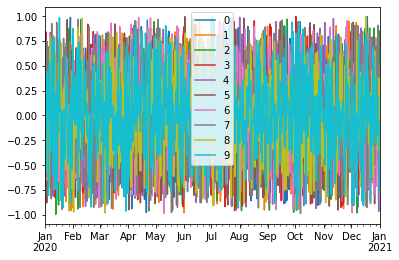

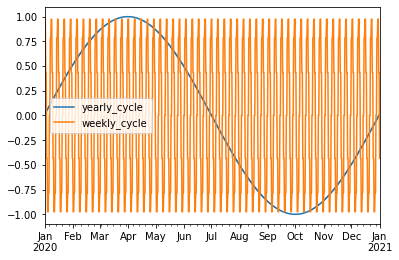

In [669]:
ts_data, ts_covariate = generate_data('12h', 10, "01-01-2020", "01-01-2021")
ts_data.plot()
ts_covariate.plot()

#### Validate dataset

In [670]:
ts_data, _ = generate_data('12h', 100, "01-01-2020", "01-01-2021")

In [671]:
ts_data.shape

(733, 100)

In [672]:
ds = MQRNNDataset(ts_data, 10)

In [673]:
curr, future = ds[1]
curr.shape

torch.Size([723, 1])

In [674]:
future.shape

torch.Size([723, 1, 10])

### Dataloader

In [675]:
class MQRNNDataLoader(pl.LightningDataModule):
    def __init__(self, df, horizon_size, train=0.8, test=0.2, samples=200, batch_size=64, workers=0):
        super().__init__()
        self.raw_data = df
        self.horizon_size = horizon_size
        self.train_size = int(train * df.shape[1])
        self.test_size = df.shape[1] - self.train_size

        self.samples = samples
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data.iloc[:, :self.train_size]
            self.train_ds = MQRNNDataset(train_df, horizon_size=self.horizon_size)

        if stage == "test" or stage is None:
            test_df = self.raw_data.iloc[:, self.train_size:]
            self.test_ds = MQRNNDataset(test_df, horizon_size=self.horizon_size)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        pass

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [676]:
dm = MQRNNDataLoader(ts_data, 10)
dm.setup()

In [677]:
x, y = next(iter(dm.train_dataloader()))

In [678]:
x.shape, y.shape

(torch.Size([64, 723, 1]), torch.Size([64, 723, 1, 10]))

## MQ-RNN

### Encoder

In [679]:
class Encoder(nn.Module):
    """
    Vanilla LSTM for Encoder part.
    """
    def __init__(self, hidden_size, num_layers):
        super().__init__()
    
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=1,
                    hidden_size=self.hidden_size,
                    num_layers=self.num_layers)
        
    def forward(self, x):
        outputs, _ = self.lstm(x.float())
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        return outputs.view(seq_len, batch_size, self.hidden_size)

In [680]:
encoder = Encoder(20, 5)

In [681]:
encoded_x = encoder(x)

In [682]:
encoded_x.shape

torch.Size([723, 64, 20])

### Decoder

#### GlobalDecoder

In [706]:
class GlobalDecoder(nn.Module):
    """
    MLP for global Decoder part.
    The MLP summarize the Encoder output and all future outputs into two contexts:
    1. A series of horizon specific context.
    2. A series of horizon agnostic for capturing the common information.
    Note - there are no specification for MLPs activation function In the paper.
    I used Sigmoid.
    """
    def __init__(self, hidden_size, horizon_size, context_size):
        super().__init__()
        
        self.encoder_input_mlp = nn.Linear(
            in_features=hidden_size,
            out_features=hidden_size * horizon_size
        ) 
        self.first_context_mlp = nn.Linear(
            in_features=horizon_size * hidden_size,
            out_features=horizon_size * hidden_size * 2
        )
        self.second_context_mlp = nn.Linear(
            in_features=horizon_size * hidden_size * 2,
            out_features=context_size * (horizon_size + 1)
            
        )
        self.activation = nn.Sigmoid()
        
        
    def forward(self, x):
        encoder_input_mlp = self.encoder_input_mlp(x)
        activated_encoder_input_mlp = self.activation(encoder_input_mlp)

        # this context handles context #1
        first_context_mlp = self.first_context_mlp(activated_encoder_input_mlp)
        activated_first_context_mlp = self.activation(first_context_mlp)

        # this context handles context #2
        second_context_mlp = self.second_context_mlp(activated_first_context_mlp)
        activated_second_context_mlp = self.activation(second_context_mlp)

        return activated_second_context_mlp
            
        

In [707]:
global_decoder = GlobalDecoder(20, 10, 20)

In [708]:
global_decoded_x = global_decoder(encoded_x)

In [709]:
global_decoded_x.shape

torch.Size([723, 64, 220])

#### LocalDecoder

In [729]:
class LocalDecoder(nn.Module):
    """
    MLP for local Decoder part.
    The MLP applys for each specific horizon and combines the corssponding future input and the contexts from
    the global Decoder.
    Note - there are no specification for MLPs activation function In the paper.
    I used both Sigmoid and ReLU.
    """
    def __init__(self, qunatiles, horizon_size, context_size):
        super().__init__()
        self_qunatiles = qunatiles
        self.qunatiles_size = len(qunatiles)
        self.horizon_size = horizon_size
        
        self.global_contexts_mlp = nn.Linear(
            in_features=context_size * (horizon_size + 1),
            out_features=horizon_size * context_size
        )
        self.future_horizons = nn.Linear(
            in_features=horizon_size * context_size,
            out_features=self.qunatiles_size * horizon_size
        )
        
        self.contexts_activation = nn.Sigmoid()
        self.quntile_activation = nn.ReLU() 
    
    def forward(self, x):
        global_contexts_mlp = self.global_contexts_mlp(x)
        activated_global_contexts_mlp = self.contexts_activation(global_contexts_mlp)

        future_horizons = self.future_horizons(activated_global_contexts_mlp)
        activated_future_horizons = self.quntile_activation(future_horizons)

        return activated_future_horizons        

### MQ-RNN Coupled

In [790]:
class MQRNN():
    def __init__(self, hidden_size, horizon_size, context_size, num_layers, qunatiles, batch_size, lr, num_epochs):
        self.hidden_size = hidden_size
        self.horizon_size = horizon_size
        self.qunatiles = qunatiles
        self.num_layers = num_layers
        self.context_size = context_size
        
        # hyperparameters
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        
        # network architecture - Seq2Seq like within Decoders interpolation
        self.encoder = Encoder(
            hidden_size=self.hidden_size,
            num_layers=self.num_layers
        )
        self.global_decoder = GlobalDecoder(
            hidden_size=self.hidden_size,
            horizon_size=self.horizon_size,
            context_size=self.context_size
        )
        self.local_decoder = LocalDecoder(
            qunatiles=self.qunatiles,
            horizon_size=self.horizon_size,
            context_size=self.context_size
        )
        
        self.encoder_optimizer = torch.optim.Adam(self.encoder.parameters(),lr=self.lr)
        self.global_decoder_optimizer = torch.optim.Adam(self.global_decoder.parameters(),lr=self.lr)
        self.local_decoder_optimizer = torch.optim.Adam(self.local_decoder.parameters(),lr=self.lr)
    
    def zero_nets_grads(self):
        self.encoder_optimizer.zero_grad()
        self.global_decoder_optimizer.zero_grad()
        self.local_decoder_optimizer.zero_grad()
    
    def step_nets_grads(self):
        self.encoder_optimizer.step()
        self.global_decoder_optimizer.step()
        self.local_decoder_optimizer.step()
        
    def calculate_loss(self, current_series, future_series):
        encoder_output = self.encoder(current_series)
        global_decoder_output = self.global_decoder(encoder_output)
        local_decoder_output = self.local_decoder(global_decoder_output)
        
        seq_len = encoder_output.shape[0]
        batch_size = encoder_output.shape[1]
        quantiles_output = local_decoder_output.view(seq_len, batch_size, self.horizon_size, len(self.qunatiles))
        
        total_loss = torch.tensor([0.])
        for idx, qunatile_prob in enumerate(self.qunatiles):
            error = future_series - quantiles_output[:, :, :, idx]
            quantile_loss = torch.max(torch.tensor([0.]), qunatile_prob * error) + torch.max(torch.tensor([0.]), (1 - qunatile_prob) * error)
            total_loss += torch.sum(quantile_loss)
            
        return total_loss
    
    def train(self, dataset):
        dataset_iteator = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        for epoch in range(self.num_epochs):
            print(f"in epoch {epoch}")
            epoch_loss = 0.
            total_input_size = 0.
            for (current_data, future_data) in dataset_iteator:
                self.zero_nets_grads()
                loss = self.calculate_loss(current_data, future_data)
                loss.backward()
                self.step_nets_grads()
                epoch_loss += loss.item()
                total_input_size += current_data.shape[0] + current_data.shape[1] + self.horizon_size
            epoch_loss_mean = epoch_loss / total_input_size
            print(f"epoch loss mean is: {epoch_loss_mean}")
            
    def sample(self, x):
        encoder_output = self.encoder(x)
        encoder_last_hidden = torch.unsqueeze(encoder_output[2], dim=0)
        global_decoder_output = self.global_decoder(encoder_last_hidden)
        local_decoder_output = self.local_decoder(global_decoder_output)
        local_decoder_qunatiles = local_decoder_output.view(self.horizon_size, len(self.qunatiles))
        return local_decoder_qunatiles[:, 0], local_decoder_qunatiles[:, -1]
        
        
            

#### Training

In [803]:
mq_rnn = MQRNN(
    hidden_size=30, 
    horizon_size=15, 
    context_size=10, 
    num_layers=2, 
    qunatiles=[.01, .25, .5, .75, .99], 
    batch_size=64, 
    lr=0.01, 
    num_epochs=20
)

In [804]:
dataset = MQRNNDataset(ts_data, 15)
mq_rnn.train(dataset=dataset)

in epoch 0
epoch loss mean is: 22804.766283524903
in epoch 1
epoch loss mean is: 14223.066411238826
in epoch 2
epoch loss mean is: 13220.278416347383
in epoch 3
epoch loss mean is: 13144.477650063856
in epoch 4
epoch loss mean is: 12721.391123882504
in epoch 5
epoch loss mean is: 12009.719667943806
in epoch 6
epoch loss mean is: 11981.905810983397
in epoch 7
epoch loss mean is: 11941.646232439336
in epoch 8
epoch loss mean is: 11896.115900383142
in epoch 9
epoch loss mean is: 11548.528097062579
in epoch 10
epoch loss mean is: 11540.960089399745
in epoch 11
epoch loss mean is: 11566.555555555555
in epoch 12
epoch loss mean is: 11573.250957854407
in epoch 13
epoch loss mean is: 11552.915389527458
in epoch 14
epoch loss mean is: 11552.25159642401
in epoch 15
epoch loss mean is: 11528.76724137931
in epoch 16
epoch loss mean is: 11543.163154533844
in epoch 17
epoch loss mean is: 11533.25
in epoch 18
epoch loss mean is: 11571.998722860792
in epoch 19
epoch loss mean is: 11548.20945083014


#### Testing

In [805]:
ts_test_data, _ = generate_data('12h', 1, "01-01-2020", "01-01-2021")

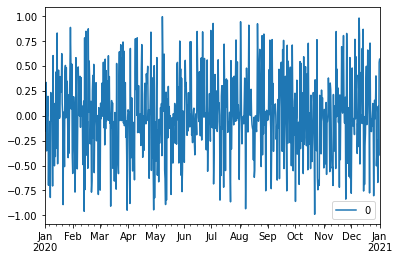

In [806]:
ts_test_data.plot()

In [807]:
ts_test_data.shape

(733, 1)

In [808]:
x = torch.tensor(ts_test_data.values)

In [809]:
x.shape

torch.Size([733, 1])

In [810]:
x = x.view(1, 733, 1)

In [811]:
first_quantile, last_quantile = mq_rnn.sample(x)
print(first_quantile)
print(last_quantile)

tensor([0.0000, 5.2382, 0.0000, 5.3153, 6.0642, 0.0000, 0.0000, 0.0000, 5.7206,
        0.0000, 0.0000, 5.6683, 0.0000, 5.1932, 5.5655])
tensor([0.0000, 0.0000, 5.1989, 0.0000, 6.1766, 5.7115, 5.3899, 0.0000, 5.6985,
        5.6433, 5.1606, 5.5149, 0.0000, 0.0000, 0.0000])


In [812]:
first_quantile = first_quantile.detach().numpy()
last_quantile = last_quantile.detach().numpy()

In [813]:
scaled_test_data = MinMaxScaler((0, 6)).fit_transform(ts_test_data[:15]).reshape(-1, 1)

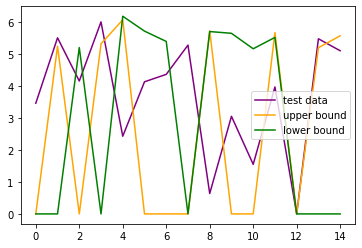

In [814]:
x_axis = [i for i in range(15)]
plt.plot(x_axis, scaled_test_data, label='test data', color='purple')
plt.plot(x_axis, first_quantile, label='upper bound', color='orange')
plt.plot(x_axis, last_quantile, label='lower bound', color='green')
plt.legend()
plt.show()

## Conclusions

### Local minimum
Due to leak of computational resouces (only CPU), I wasn't manage to train general enough MQ-RNN network model (the setup horizon is 15 which is pretty small).
From the training phase, it seems because the network isn't generalized enough it got stuck on local minimum and can't continue and derivate correctly the loss function.

### Dataset prepartion and overfitting
I created time series samples from different sinusoidal functions hold different mangintudes.
From some reason that I didn't figure out yet, the for sequencing doesn't create the correct horizons and therefroe the contexts is overfitted on the training data.
I believe it might be because my last activation function is ReLU, but if I will leave it to other kind of activation it will probably cause to gardient vanishing issues.